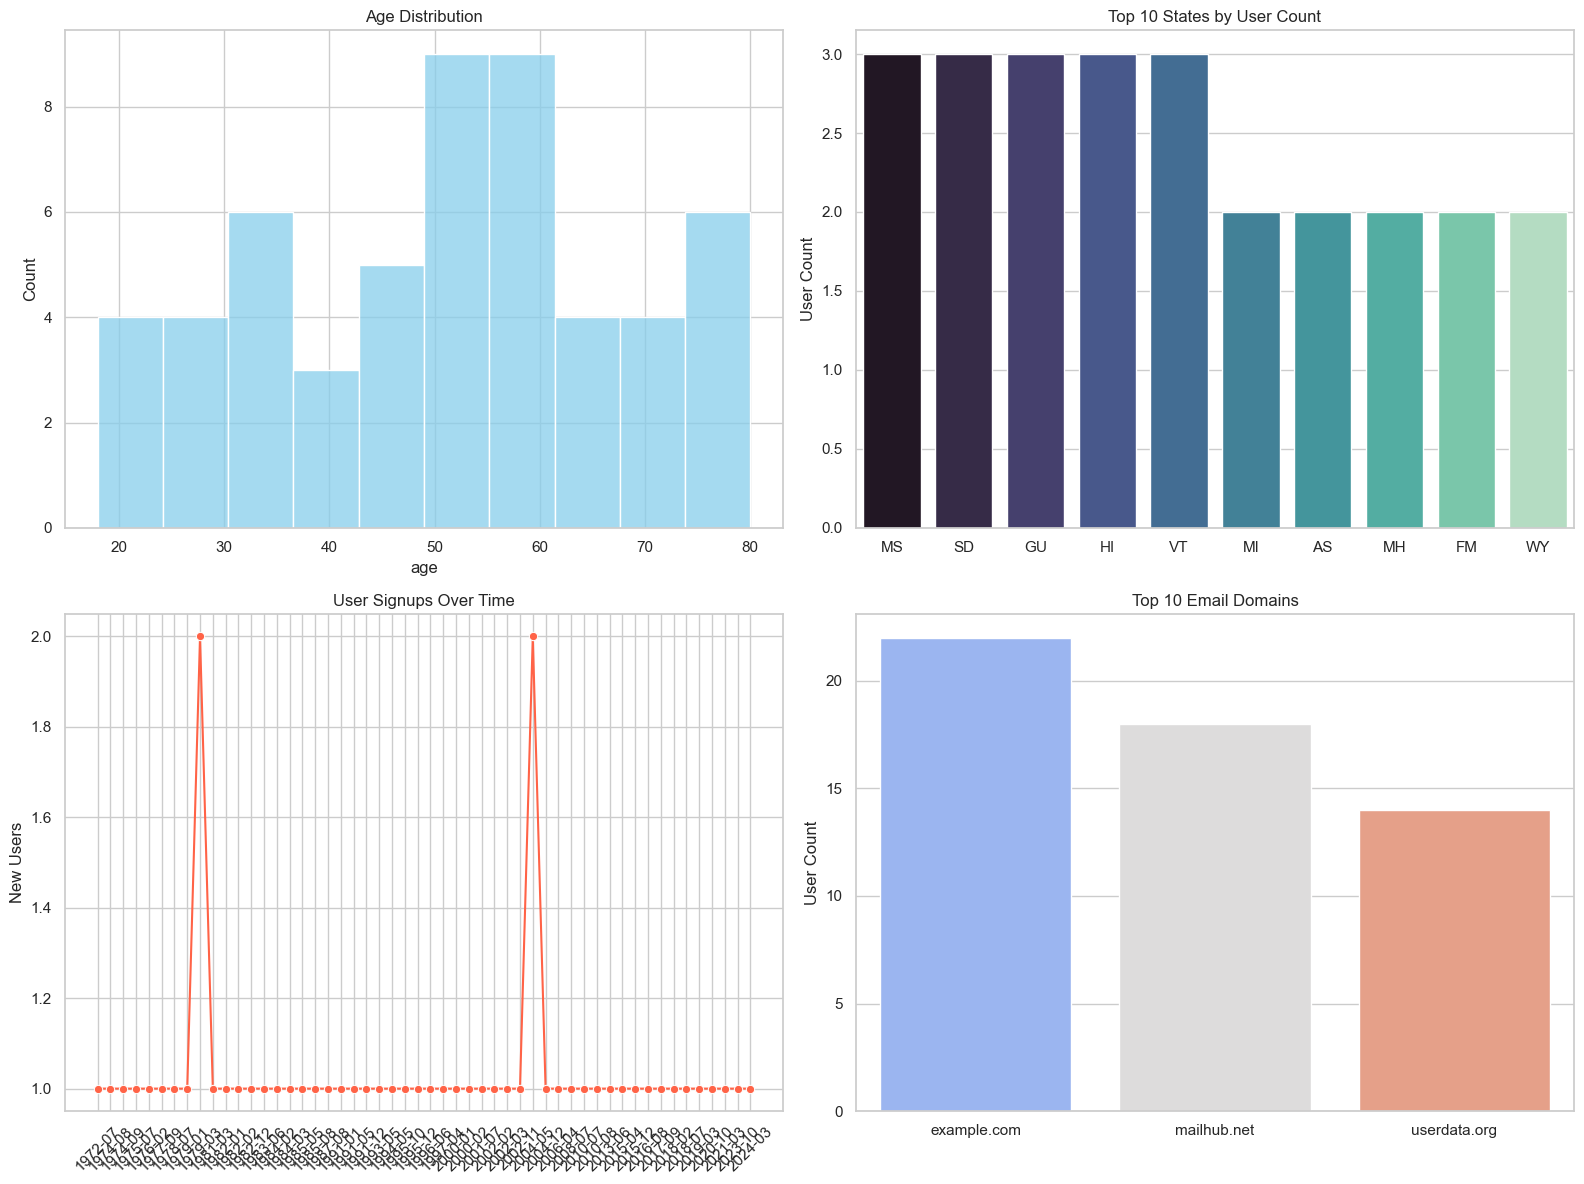

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIGURATION ===
data_dir = "" #use path 

# === LOAD JSONL DATA ===
records = []

for file in os.listdir(data_dir):
    if file.startswith("kinesis-to-s3"):
        file_path = os.path.join(data_dir, file)
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                try:
                    record = json.loads(line)
                    records.append(record)
                except json.JSONDecodeError:
                    continue  # Skip invalid JSON lines

# === CONVERT TO DATAFRAME ===
df = pd.DataFrame(records)

# === PREPROCESS DATA ===
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['created_month'] = df['created_at'].dt.to_period('M')
df['state'] = df['address'].str.extract(r', (\w{2}) \d{5}')
df['email_domain'] = df['email'].str.extract(r'@([\w\.-]+)')
df['area_code'] = df['phone_number'].str.extract(r'\(?(\d{3})\)?')

# === VISUALIZATION SETUP ===
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# 1. Age Distribution
sns.histplot(df['age'].dropna(), bins=10, ax=axs[0, 0], color='skyblue')
axs[0, 0].set_title("Age Distribution")

# 2. Top 10 States by User Count
state_counts = df['state'].value_counts().head(10)
sns.barplot(x=state_counts.index, y=state_counts.values, ax=axs[0, 1], palette='mako')
axs[0, 1].set_title("Top 10 States by User Count")
axs[0, 1].set_ylabel("User Count")

# 3. Signups Over Time
created_counts = df['created_month'].value_counts().sort_index()
sns.lineplot(x=created_counts.index.astype(str), y=created_counts.values, ax=axs[1, 0], marker='o', color='tomato')
axs[1, 0].set_title("User Signups Over Time")
axs[1, 0].tick_params(axis='x', rotation=45)
axs[1, 0].set_ylabel("New Users")

# 4. Top Email Domains
domain_counts = df['email_domain'].value_counts().head(10)
sns.barplot(x=domain_counts.index, y=domain_counts.values, ax=axs[1, 1], palette='coolwarm')
axs[1, 1].set_title("Top 10 Email Domains")
axs[1, 1].set_ylabel("User Count")

plt.tight_layout()
plt.show()
